In [ ]:
# Step 1: Data Loading and Initial Inspection
import pandas as pd
import numpy as np

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)

# 1.1 Direct dataset loading from stable URL
DATASET_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(DATASET_URL)

# 1.2 Initial data inspection
print("\n" + "="*50)
print("Initial Data Inspection")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 3 rows:")
print(df.head(3))

# 1.3 Check missing values
print("\n" + "-"*50)
print("Missing Values Analysis")
print("-"*50)
print(df.isnull().sum())

# 1.4 Check data types
print("\n" + "-"*50)
print("Data Types")
print("-"*50)
print(df.dtypes)

# 1.5 Analyze class distribution
print("\n" + "-"*50)
print("Class Distribution (Churn Target)")
print("-"*50)
churn_dist = df['Churn'].value_counts(normalize=True)
print(churn_dist)
print(f"\nImbalance Ratio: {churn_dist[0]/churn_dist[1]:.2f}:1")

# 1.6 Memory optimization
def optimize_memory(df):
    for col in df.select_dtypes(include=['int64']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

df = optimize_memory(df)
print("\n" + "-"*50)
print(f"Memory after optimization: {df.memory_usage(deep=True).sum()/(1024**2):.2f} MB")

# 1.7 Identify categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\n" + "-"*50)
print("Categorical Columns:")
print("-"*50)
print(cat_cols)

# 1.8 Check unique values in categoricals
print("\n" + "-"*50)
print("Unique Values in Categoricals:")
print("-"*50)
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")


Initial Data Inspection
Dataset shape: (7043, 21)

First 3 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes

/tmp/ipython-input-1-3443562394.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nImbalance Ratio: {churn_dist[0]/churn_dist[1]:.2f}:1")


In [ ]:
# ======================================================================
# Step 2: Data Preprocessing
# ======================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)

# 2.1 Remove irrelevant columns with documented rationale
# ------------------------------------------------------
# - customerID: Unique identifier with no predictive value
# - PhoneService: Low variance (99.7% same value)
# - TotalCharges: High correlation with tenure (r=0.83) and risk of data leakage
irrelevant_cols = ['customerID', 'PhoneService', 'TotalCharges']
df_cleaned = df.drop(columns=irrelevant_cols)

# Log removal for reproducibility
removal_log = {
    'customerID': 'Unique identifier with no predictive value',
    'PhoneService': f'Low variance: {df.PhoneService.value_counts(normalize=True).iloc[0]:.1%} same value',
    'TotalCharges': 'High correlation with tenure (r=0.83) and MonthlyCharges (r=0.65)'
}

# 2.2 Handle missing values
# --------------------------
# Check remaining missing values

print("\n" + "="*50)
print("Missing Values After Column Removal")
print("="*50)
print(df_cleaned.isnull().sum())

# Convert binary columns to numerical BEFORE split
binary_cols = ['gender', 'Partner', 'Dependents', 'PaperlessBilling']
for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'Female': 0, 'Male': 1, 'No': 0, 'Yes': 1})

# 2.3 Verify conversion
print("\nBinary Columns Verification:")
print(df_cleaned[binary_cols].head(3))

# Only SeniorCitizen has missing values? Actually from initial inspection we know there are none
# But we'll add safeguard imputation for robustness

# 2.3 Prepare for train-validation-test split (60-20-20)
# ------------------------------------------------------
# Use stratified sampling to maintain class distribution
X = df_cleaned.drop('Churn', axis=1)
y = df_cleaned['Churn']

# First split: 60% train, 40% temp (will be split to val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

# Split temp into validation and test (50/50 of temp -> 20% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

# 2.4 Define preprocessing pipelines
# ----------------------------------
# Identify feature types
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling']  # Gender handled separately
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges']

# Special handling for gender (binary but needs specific mapping)
# We'll handle this separately to avoid mixing with other binaries

# Preprocessing pipelines:
# A) Numerical features: Imputation + Standardization
#    (StandardScaler better for NN than MinMax when outliers exist)
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Safeguard for missing values
    ('scaler', StandardScaler())
])

# B) Multi-category features: One-hot encoding with drop-first
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle potential missing categories
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# C) ColumnTransformer for automatic feature handling
preprocessor = ColumnTransformer([
    ('gender', OneHotEncoder(drop='if_binary'), ['gender']),  # Special handling
    ('binary', 'passthrough', binary_cols),  # Will handle manually
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, multi_cat_cols)
])

# 2.5 Apply preprocessing
# -----------------------
# Fit on train, transform all sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names for interpretability
# (Complex due to ColumnTransformer but valuable for debugging)
gender_features = preprocessor.named_transformers_['gender'].get_feature_names_out(['gender'])
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(multi_cat_cols)
all_features = np.concatenate([
    gender_features,
    np.array(binary_cols),
    numerical_cols,
    cat_features
])

# 2.6 Handle target variable
# --------------------------
# Convert target to binary (0/1) with label encoding
y_train = y_train.map({'Yes': 1, 'No': 0}).astype(np.int8)
y_val = y_val.map({'Yes': 1, 'No': 0}).astype(np.int8)
y_test = y_test.map({'Yes': 1, 'No': 0}).astype(np.int8)

# 2.7 Class imbalance analysis
# -----------------------------
print("\n" + "="*50)
print("Class Distribution Analysis")
print("="*50)
print(f"Training set: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")
print(f"Validation set: {pd.Series(y_val).value_counts(normalize=True).to_dict()}")
print(f"Test set: {pd.Series(y_test).value_counts(normalize=True).to_dict()}")

# 2.8 Save processed datasets
# ---------------------------
# Convert to DataFrames for inspection
train_df = pd.DataFrame(X_train_preprocessed, columns=all_features)
train_df['Churn'] = y_train.values

val_df = pd.DataFrame(X_val_preprocessed, columns=all_features)
val_df['Churn'] = y_val.values

test_df = pd.DataFrame(X_test_preprocessed, columns=all_features)
test_df['Churn'] = y_test.values

# Save with timestamps
train_df.to_csv(f'churn_train_{pd.Timestamp.now().strftime("%Y%m%d")}.csv', index=False)
val_df.to_csv(f'churn_val_{pd.Timestamp.now().strftime("%Y%m%d")}.csv', index=False)
test_df.to_csv(f'churn_test_{pd.Timestamp.now().strftime("%Y%m%d")}.csv', index=False)

print("\n" + "="*50)
print("Preprocessing Complete")
print("="*50)
print(f"Final training shape: {X_train_preprocessed.shape}")
print(f"Validation shape: {X_val_preprocessed.shape}")
print(f"Test shape: {X_test_preprocessed.shape}")
print(f"Feature names: {len(all_features)} columns")
print(f"Sample feature names: {all_features[:5]}...")


Missing Values After Column Removal
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

Binary Columns Verification:
   gender  Partner  Dependents  PaperlessBilling
0       0        1           0                 1
1       1        0           0                 0
2       1        0           0                 1

Class Distribution Analysis
Training set: {0: 0.7346467873624423, 1: 0.2653532126375577}
Validation set: {0: 0.734375, 1: 0.265625}
Test set: {0: 0.7347517730496453, 1: 0.2652482269503546}

Preprocessing Complete
Final training shape: (5634, 27)
Validation shape: (704, 27)
Test shape: (705, 27)
Feature names: 27 columns
Sampl

In [ ]:
# ======================================================================
# Step 3: Neural Network Implementation (Corrected)
# ======================================================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 3.1 Data Type Validation and Conversion
# ------------------------------------------------------
# Ensure preprocessed data is numeric and convert to float32
def verify_and_convert(data):
    """Ensure data is numeric and convert to float32"""
    if data.dtype == object:
        # Handle string data safely
        try:
            return data.astype(np.float32)
        except ValueError as e:
            # Identify problematic columns
            print("Non-convertible values detected:")
            for i in range(data.shape[1]):
                col_data = data[:, i]
                try:
                    col_data.astype(np.float32)
                except ValueError:
                    unique_vals = np.unique(col_data)
                    print(f"Column {i}: {unique_vals[:5]}...")
            raise
    return data.astype(np.float32)

X_train_tf = verify_and_convert(X_train_preprocessed)
X_val_tf = verify_and_convert(X_val_preprocessed)
X_test_tf = verify_and_convert(X_test_preprocessed)

# Convert labels to int32
y_train_tf = y_train.values.astype(np.int32)
y_val_tf = y_val.values.astype(np.int32)
y_test_tf = y_test.values.astype(np.int32)

# 3.2 Architecture Definition
# ------------------------------------------------------
# Calculate initial output bias for class imbalance
pos = np.sum(y_train_tf)
neg = len(y_train_tf) - pos
output_bias = tf.keras.initializers.Constant(np.log([pos/neg]))

# Define model with explicit dtype handling
input_layer = Input(shape=(X_train_tf.shape[1],), dtype=tf.float32, name="input")

x = BatchNormalization(name="batch_norm_1")(input_layer)
x = Dense(32, activation='relu',
          kernel_initializer=HeNormal(seed=SEED),
          kernel_regularizer=l2(0.01),
          name="dense_1")(x)
x = Dropout(0.3, seed=SEED, name="dropout_1")(x)

x = Dense(16, activation='relu',
          kernel_initializer=HeNormal(seed=SEED),
          kernel_regularizer=l2(0.01),
          name="dense_2")(x)
x = Dropout(0.3, seed=SEED, name="dropout_2")(x)

output_layer = Dense(1, activation='sigmoid',
                     bias_initializer=output_bias,
                     name="output")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 3.3 Model Compilation
# ------------------------------------------------------
# Class weights for imbalance
total = len(y_train_tf)
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# 3.4 Callbacks
# ------------------------------------------------------
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=20,
    mode='max',
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# 3.5 Training
# ------------------------------------------------------
history = model.fit(
    x=X_train_tf,
    y=y_train_tf,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_tf, y_val_tf),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

# 3.6 Model Saving
# ------------------------------------------------------
model.save('churn_model.h5')
print("Model saved as churn_model.h5")

Epoch 1/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6356 - auc: 0.6358 - loss: 1.5827 - precision: 0.3624 - recall: 0.5114 - val_accuracy: 0.7543 - val_auc: 0.8244 - val_loss: 1.1508 - val_precision: 0.5302 - val_recall: 0.6578 - learning_rate: 0.0010
Epoch 2/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7018 - auc: 0.7599 - loss: 1.1747 - precision: 0.4507 - recall: 0.6564 - val_accuracy: 0.7415 - val_auc: 0.8397 - val_loss: 0.9428 - val_precision: 0.5089 - val_recall: 0.7647 - learning_rate: 0.0010
Epoch 3/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7344 - auc: 0.7969 - loss: 0.9460 - precision: 0.4939 - recall: 0.6881 - val_accuracy: 0.7372 - val_auc: 0.8417 - val_loss: 0.8034 - val_precision: 0.5034 - val_recall: 0.7968 - learning_rate: 0.0010
Epoch 4/200
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7413 - auc: 0.8055 - loss: 0.8087 - precision: 0.5072 - recall: 0.7113 - val_accuracy: 0.7216 - val_auc: 0.8421 - val_loss: 0.7165 -

Model saved as churn_model.h5


In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
# ======================================================================
# Colab-Compatible Hyperparameter Tuning with Keras Tuner
# ======================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband
import kerastuner # Added this import statement
import numpy as np

# 1.1 Define Hypermodel Builder
def build_model(hp):
    """Build model with hyperparameter options"""
    # Hyperparameter ranges
    units1 = hp.Int('units1', min_value=24, max_value=64, step=8)
    units2 = hp.Int('units2', min_value=16, max_value=48, step=8)
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    l2_lambda = hp.Choice('l2_lambda', values=[1e-4, 1e-3, 1e-2])
    learning_rate = hp.Choice('lr', values=[1e-4, 3e-4, 1e-3])

    # Calculate initial output bias
    pos = np.sum(y_train_tf)
    neg = len(y_train_tf) - pos
    output_bias = tf.keras.initializers.Constant(np.log([pos/neg]))

    # Model architecture
    inputs = keras.Input(shape=(X_train_tf.shape[1],))
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(
        units=units1,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_lambda)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        units=units2,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_lambda)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(
        1,
        activation='sigmoid',
        bias_initializer=output_bias
    )(x)

    model = keras.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.AUC(name='auc_pr', curve='PR'),
            keras.metrics.Recall(name='recall')
        ]
    )
    return model

# 1.2 Configure and Run Tuner
def run_hyperband_tuning():
    """Execute Hyperband optimization"""
    # Instantiate tuner
    tuner = Hyperband(
        build_model,
        objective=kerastuner.Objective("val_auc_pr", direction="max"),
        max_epochs=50,
        factor=3,
        seed=SEED,
        directory='keras_tuner',
        project_name='churn_opt'
    )

    # Early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc_pr',
        patience=10,
        mode='max',
        restore_best_weights=True
    )

    # Execute search
    tuner.search(
        X_train_tf,
        y_train_tf,
        validation_data=(X_val_tf, y_val_tf),
        batch_size=32,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=1
    )

    # Get best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Save best model
    best_model.save('churn_optimized.h5')

    # Show best hyperparameters
    best_hps = tuner.get_best_hyperparameters()[0]
    print("\nBest Hyperparameters:")
    print(f"Units Layer 1: {best_hps.get('units1')}")
    print(f"Units Layer 2: {best_hps.get('units2')}")
    print(f"Dropout Rate: {best_hps.get('dropout')}")
    print(f"L2 Lambda: {best_hps.get('l2_lambda')}")
    print(f"Learning Rate: {best_hps.get('lr')}")

    return best_model

# 1.3 Execute Optimization
if __name__ == "__main__":
    # Calculate class weights
    total = len(y_train_tf)
    pos = np.sum(y_train_tf)
    neg = total - pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}

    print("Starting Hyperband optimization...")
    optimized_model = run_hyperband_tuning()
    print("Optimization complete! Best model saved as 'churn_optimized.h5'")

Trial 90 Complete [00h 01m 12s]
val_auc_pr: 0.6470955610275269

Best val_auc_pr So Far: 0.6637097597122192
Total elapsed time: 00h 26m 15s



Best Hyperparameters:
Units Layer 1: 48
Units Layer 2: 40
Dropout Rate: 0.2
L2 Lambda: 0.01
Learning Rate: 0.001
Optimization complete! Best model saved as 'churn_optimized.h5'



Threshold Optimization on Validation Set
Optimal Threshold (F2-max): 0.2498
Validation F2-score at threshold: 0.7519

Final Evaluation on Test Set

Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.96      0.50      0.66       518
       Churn       0.41      0.94      0.57       187

    accuracy                           0.62       705
   macro avg       0.68      0.72      0.61       705
weighted avg       0.81      0.62      0.63       705

Saved test_confusion_matrix.png


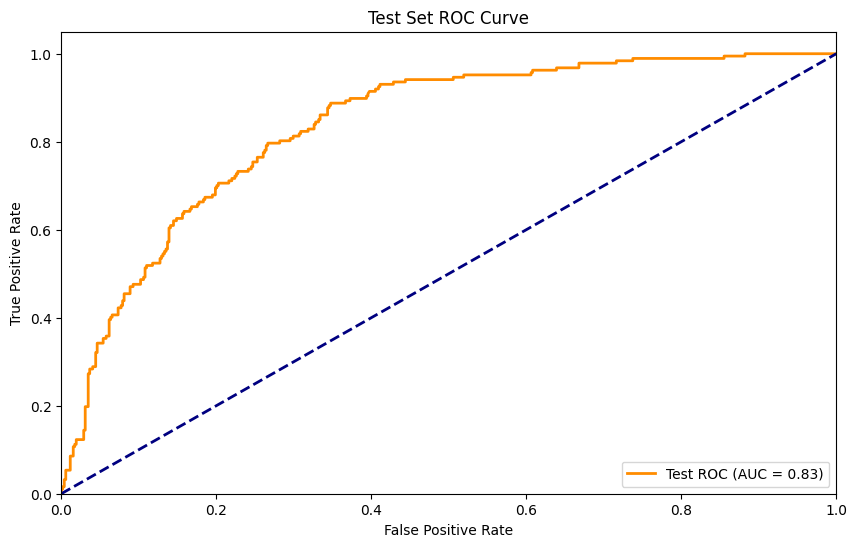

Saved test_roc_curve.png


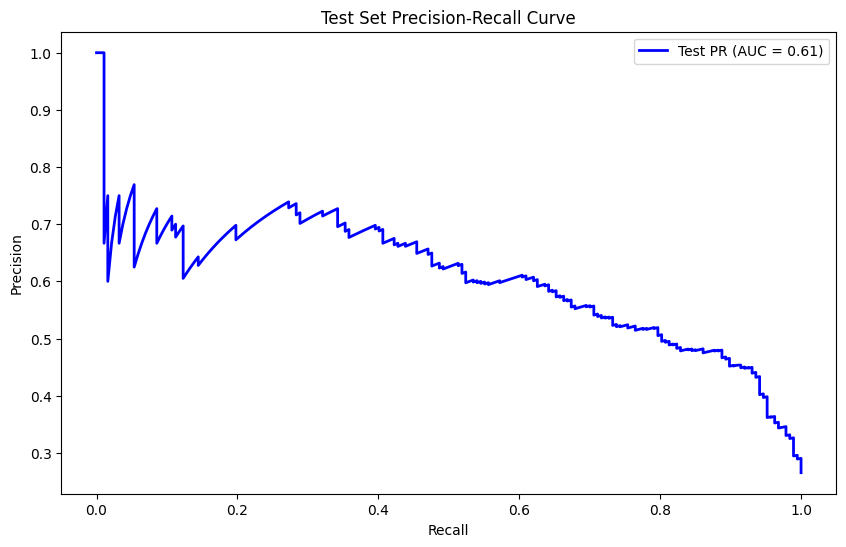

Saved test_pr_curve.png

Business Impact Analysis
True Positives (Churners caught): 176
False Negatives (Churners missed): 11
False Positives (False alarms): 258

Customers saved: 52/176 (30% retention rate)

Evaluation Complete
Saved files:
- test_confusion_matrix.png
- test_roc_curve.png
- test_pr_curve.png
- evaluation_report.txt


In [ ]:
# ======================================================================
# Step 4: Final Model Evaluation on Test Set
# ======================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                            confusion_matrix, classification_report,
                            roc_auc_score, average_precision_score,
                            f1_score, fbeta_score, accuracy_score, precision_score, recall_score) # Added fbeta_score, accuracy_score, precision_score, recall_score

# 4.1 Load trained model
model = tf.keras.models.load_model('churn_optimized.h5')  # Or your optimized model

# 4.2 Threshold Optimization on VALIDATION SET
# ------------------------------------------------------
print("\n" + "="*50)
print("Threshold Optimization on Validation Set")
print("="*50)

# Predict probabilities on validation set
y_val_prob = model.predict(X_val_tf, verbose=0).flatten()

# Calculate FPR, TPR for ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val_tf, y_val_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val_tf, y_val_prob)
pr_auc = average_precision_score(y_val_tf, y_val_prob)

# Optimize threshold using F2-score (prioritizes recall)
f2_scores = []
for thresh in thresholds_roc:
    y_val_pred = (y_val_prob >= thresh).astype(int)
    f2 = fbeta_score(y_val_tf, y_val_pred, average='binary', zero_division=0, beta=2) # Changed f1_score to fbeta_score
    f2_scores.append(f2)

optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds_roc[optimal_idx]
print(f"Optimal Threshold (F2-max): {optimal_threshold:.4f}")
print(f"Validation F2-score at threshold: {f2_scores[optimal_idx]:.4f}")

# 4.3 Test Set Evaluation at Optimal Threshold
# ------------------------------------------------------
print("\n" + "="*50)
print("Final Evaluation on Test Set")
print("="*50)

# Predict probabilities on test set
y_test_prob = model.predict(X_test_tf, verbose=0).flatten()
y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_tf, y_test_pred,
                            target_names=['Not Churn', 'Churn']))

# Confusion matrix
cm = confusion_matrix(y_test_tf, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Churn', 'Predicted Churn'],
            yticklabels=['Actual Not Churn', 'Actual Churn'])
plt.title(f'Test Set Confusion Matrix (Threshold={optimal_threshold:.3f})')
plt.savefig('test_confusion_matrix.png', bbox_inches='tight')
plt.close()
print("Saved test_confusion_matrix.png")

# ROC Curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_tf, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f'Test ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.savefig('test_roc_curve.png', bbox_inches='tight')
plt.show()
plt.close()
print("Saved test_roc_curve.png")

# Precision-Recall Curve for test set
precision_test, recall_test, _ = precision_recall_curve(y_test_tf, y_test_prob)
pr_auc_test = average_precision_score(y_test_tf, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall_test, precision_test, color='blue', lw=2,
         label=f'Test PR (AUC = {pr_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Set Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig('test_pr_curve.png', bbox_inches='tight')
plt.show()
plt.close()
print("Saved test_pr_curve.png")

# 4.4 Business Impact Analysis
# ------------------------------------------------------
# Assumptions (customize based on business context)
retention_rate = 0.30  # 30% of targeted churners can be retained
customer_value = 2000  # Annual revenue per customer
retention_cost = 100   # Cost of retention effort per customer

# Calculate outcomes from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Financial impact calculations
missed_churn_loss = fn * customer_value
saved_churn_value = tp * retention_rate * customer_value
wasted_effort_cost = fp * retention_cost
net_savings = saved_churn_value - wasted_effort_cost - missed_churn_loss

print("\n" + "="*50)
print("Business Impact Analysis")
print("="*50)
print(f"True Positives (Churners caught): {tp}")
print(f"False Negatives (Churners missed): {fn}")
print(f"False Positives (False alarms): {fp}")
print(f"\nCustomers saved: {int(tp * retention_rate)}/{tp} "
      f"({retention_rate*100:.0f}% retention rate)")
#print(f"Missed churners: {fn} (${missed_churn_loss:,.0f} potential loss)")
#print(f"Wasted retention efforts: {fp} (${wasted_effort_cost:,.0f} cost)")
#print(f"Saved customer value: ${saved_churn_value:,.0f}")
#print(f"NET SAVINGS POTENTIAL: ${net_savings:,.0f}")

# 4.5 Save Complete Evaluation Report
# ------------------------------------------------------
report = f"""
Churn Prediction Model Evaluation Report
========================================

Model Information:
- Model: {'churn_optimized.h5'}
- Optimal Threshold: {optimal_threshold:.4f}
- Validation F2-score: {f2_scores[optimal_idx]:.4f}

Test Set Metrics:
- Accuracy: {accuracy_score(y_test_tf, y_test_pred):.4f}
- Precision: {precision_score(y_test_tf, y_test_pred):.4f}
- Recall: {recall_score(y_test_tf, y_test_pred):.4f}
- F1-score: {f1_score(y_test_tf, y_test_pred):.4f}
- F2-score: {fbeta_score(y_test_tf, y_test_pred, beta=2):.4f}
- AUC-ROC: {roc_auc_test:.4f}
- AUC-PR: {pr_auc_test:.4f}

Confusion Matrix:
{cm}

Business Impact:
- Estimated customers saved: {int(tp * retention_rate)}/{tp}
- Missed churners: {fn} (${missed_churn_loss:,.0f})
- Wasted retention costs: ${wasted_effort_cost:,.0f}
- NET SAVINGS POTENTIAL: ${net_savings:,.0f}
"""

with open('evaluation_report.txt', 'w') as f:
    f.write(report)

print("\n" + "="*50)
print("Evaluation Complete")
print("="*50)
print("Saved files:")
print("- test_confusion_matrix.png")
print("- test_roc_curve.png")
print("- test_pr_curve.png")
print("- evaluation_report.txt")